In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["font.size"] = 16

import qiskit.pulse as pulse
from qiskit.quantum_info.states import Statevector
from qiskit_dynamics import Solver, Signal
from qiskit_dynamics.pulse import InstructionToSignals

In [2]:
Omega_01 = 5.5  # Ghz
Delta = -0.25
Omega_02 = 2 * Omega_01 + Delta
Lambda = 0.8

ket0 = np.array([[1, 0, 0]]).T
ket1 = np.array([[0, 1, 0]]).T
ket2 = np.array([[0, 0, 1]]).T

sigma_m1 = ket0 @ ket1.T.conj()
sigma_m2 = ket1 @ ket2.T.conj()

sigma_p1 = sigma_m1.T.conj()
sigma_p2 = sigma_m2.T.conj()

P0, P1, P2 = ket0 @ ket0.T.conj(), ket1 @ ket1.T.conj(), ket2 @ ket2.T.conj()

In [3]:
# drift, control, R_frame
drift = 2 * np.pi * (Omega_01 * P1 + Omega_02 * P2)
control = [2 * np.pi * (sigma_p1 + sigma_m1 + Lambda * (sigma_p2 + sigma_m2))]
R_frame = 2 * np.pi * (Omega_01 * P1 + 2 * Omega_01 * P2)

In [4]:
y0 = Statevector([1.0, 0.0, 0.0])
dt = 0.1
area = 0.42
sigma = 5  # ns
amp = area / sigma
sigma = sigma / dt  # ns

duration = np.math.ceil(sigma * 5)
T = duration * dt  # ns

In [5]:
# construct the solver
hamiltonian_solver = Solver(
    static_hamiltonian=drift,
    hamiltonian_operators=control,
    rotating_frame=R_frame,
    rwa_cutoff_freq=1.5 * Omega_01,
    rwa_carrier_freqs=[Omega_01],
)

In [6]:
def make_signal(duration, amp, sigma, w, waveform, dt=dt):

    with pulse.build(name="spec") as spec:
        if waveform == "g":
            pulse.play(
                pulse.Gaussian(duration=duration, amp=amp, sigma=sigma),
                pulse.DriveChannel(0),
            )
        elif waveform == "d":
            pulse.play(
                pulse.Drag(duration=duration, amp=amp, sigma=sigma, beta=2.0),
                pulse.DriveChannel(0),
            )

    converter = InstructionToSignals(dt, carriers={"d0": w})
    signals = converter.get_signals(spec)
    return signals  # , spec.draw()

In [7]:
def solve(duration, amp, sigma, omega_d, waveform, dt=dt):
    solutions = hamiltonian_solver.solve(
        t_span=[0.0, T],
        y0=y0,
        t_eval=np.linspace(0, T, 101),
        signals=[make_signal(duration, amp, sigma, w, waveform, dt) for w in omega_d],
    )
    return solutions

In [8]:
w_range = Omega_01 + np.linspace(-1,1,50)

%time solutions_g = solve(duration, amp, sigma, w_range, 'g')
max_amp_g = np.array([sol.y[51].probabilities() for sol in solutions_g])

%time solutions_d = solve(duration, amp, sigma, w_range, 'd')
max_amp_d = np.array([sol.y[51].probabilities() for sol in solutions_d])

CPU times: user 1min 42s, sys: 144 ms, total: 1min 42s
Wall time: 1min 42s
CPU times: user 1min 38s, sys: 93.7 ms, total: 1min 38s
Wall time: 1min 38s


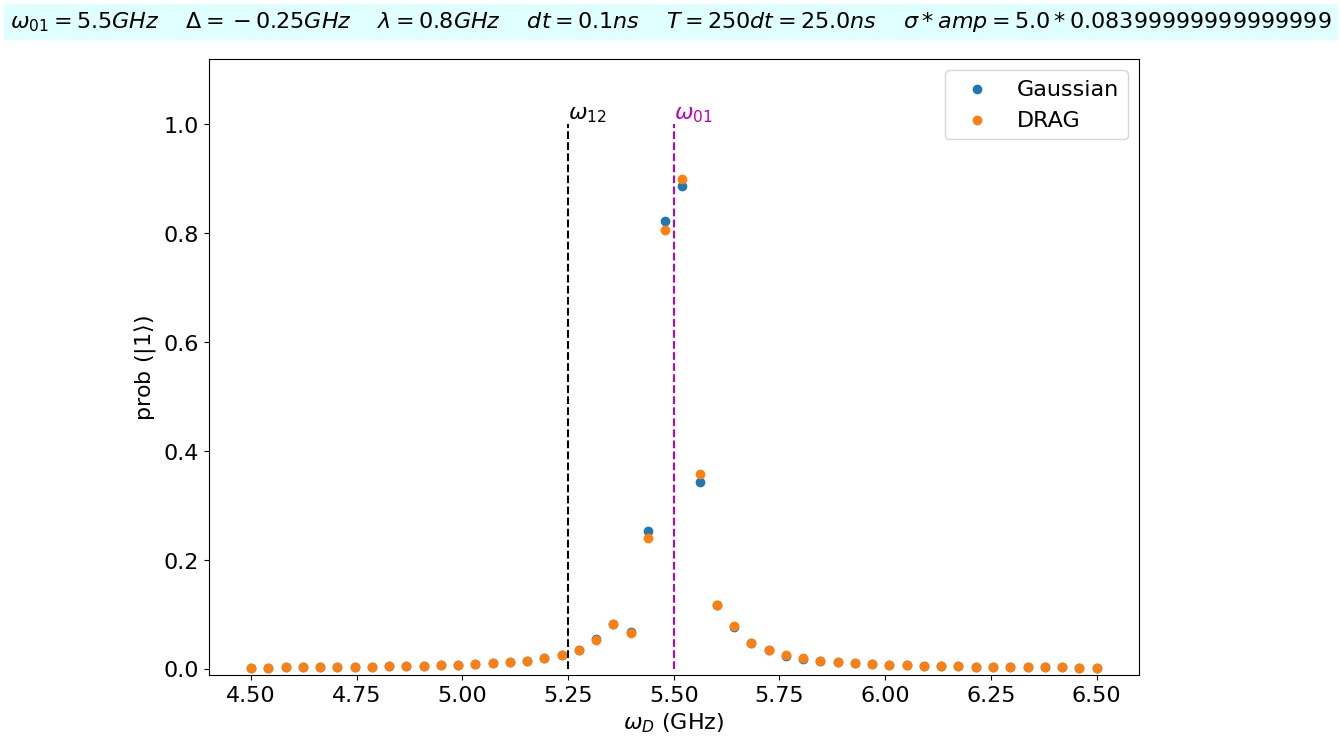

In [9]:
plt.close()
fig, ax = plt.subplots(1,1, figsize = (12,8))
ax.scatter((Omega_01 + np.linspace(-1,1,50)), max_amp_g[:,1], label = 'Gaussian')
ax.scatter((Omega_01 + np.linspace(-1,1,50)), max_amp_d[:,1], label = 'DRAG')
ax.legend()
ax.plot([Omega_01 + Delta, Omega_01 + Delta], [0,1], '--k')
ax.plot([Omega_01, Omega_01], [0,1], '--m')
ax.text(Omega_01, 1.01, "$\omega_{01}$",c='m')
ax.text(Omega_01 + Delta, 1.01, "$\omega_{12}$")
ax.set_ylim(-0.012,1.12)
ax.set_xlabel("$\omega_D$ (GHz)")
ax.set_ylabel(r"prob $(|1\rangle)$")

fig.text(
    0.51,
    0.92,
    (
        f"$\omega_{{01}} = {Omega_01} GHz$    "
        + f"$\Delta = {Delta} GHz$    "
        + f"$\lambda = {Lambda} GHz$    "
        + f"$dt = {dt} ns$    "
        + f"$T = {duration}dt = {T} ns$    "
        + f"$\sigma * amp = {sigma*dt}*{amp}$"
    ),
    backgroundcolor="lightcyan",
    fontsize=16,
    horizontalalignment="center",
);

In [10]:
w_range = Omega_01 + np.linspace(-1,1,50)

%time solutions_g = solve(duration, amp*5, sigma/5, w_range, 'g')
max_amp_g = np.array([sol.y[51].probabilities() for sol in solutions_g])

%time solutions_d = solve(duration, amp*5, sigma/5, w_range, 'd')
max_amp_d = np.array([sol.y[51].probabilities() for sol in solutions_d])

CPU times: user 1min 47s, sys: 479 ms, total: 1min 47s
Wall time: 1min 47s
CPU times: user 1min 47s, sys: 411 ms, total: 1min 47s
Wall time: 1min 47s


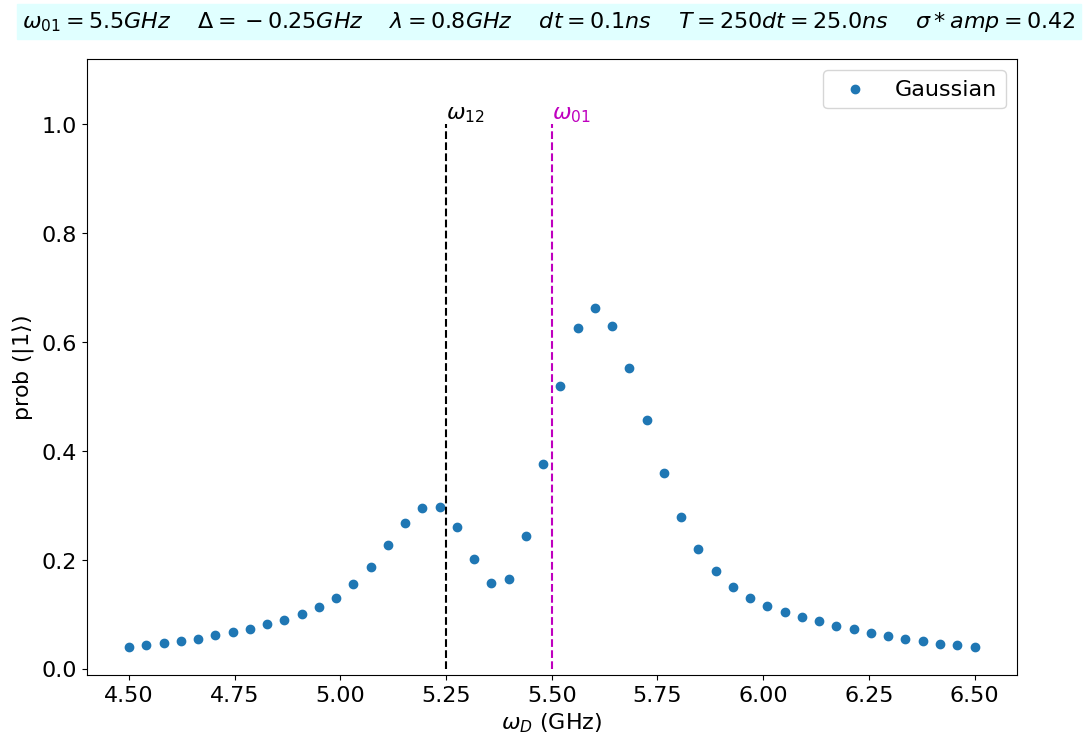

In [11]:
plt.close()
fig, ax = plt.subplots(1,1, figsize = (12,8))
ax.scatter((Omega_01 + np.linspace(-1,1,50)), max_amp_g[:,1], label = 'Gaussian')
# ax.scatter((Omega_01 + np.linspace(-1,1,50)), max_amp_d[:,1], label = 'DRAG')
ax.legend()
ax.plot([Omega_01 + Delta, Omega_01 + Delta], [0,1], '--k')
ax.plot([Omega_01, Omega_01], [0,1], '--m')
ax.text(Omega_01, 1.01, "$\omega_{01}$",c='m')
ax.text(Omega_01 + Delta, 1.01, "$\omega_{12}$")
ax.set_ylim(-0.012,1.12)
ax.set_xlabel("$\omega_D$ (GHz)")
ax.set_ylabel(r"prob $(|1\rangle)$")

fig.text(
    0.51,
    0.92,
    (
        f"$\omega_{{01}} = {Omega_01} GHz$    "
        + f"$\Delta = {Delta} GHz$    "
        + f"$\lambda = {Lambda} GHz$    "
        + f"$dt = {dt} ns$    "
        + f"$T = {duration}dt = {T} ns$    "
        + f"$\sigma * amp = {area}$"
    ),
    backgroundcolor="lightcyan",
    fontsize=16,
    horizontalalignment="center",
);
